In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

# How to use this pipeline
1) define files to be used in reduction (needed to pass into data_pipeline
2) set specset = data_pipeline fcn 
3) use data_pipeline outputted graphs to estimate wl & pixel matches
4) use guess_plot to get linelist matches to refine pixel estimates 
5) collect ~5 of these in lists
6) use refine_guesses (&define target filename to use) to populate more matches based on inital guesses & plot residuals
7) 


In [2]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [3]:
def data_pipeline(flatfiles,atlasfiles,arcfiles,linelist):
    #Overscan the flats
    rflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',flatfiles)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    
    #small scale flat creationg - normalized
    rnfl = reduce_dblspec.create_normalized_flat(rflats)

    header = atlasfiles[0].header    
    redspecnoao = atlasfiles[0].data
    redwlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(redspecnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(rnfl), (320, 360))
    
        
    #outputs graphs of atlas & arcs
    plt.figure(figsize=(20,5))
    plt.plot(redwlnoao, redspecnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    plt.xlim(5000,10000)
    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum or Dispersion Solution?-pixels')
    ds.plot_spec()
    
    specset = (ds, redwlnoao, redspecnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [9]:
def goodness_of_matches(targetfile, guesses):
    rflats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',flatfiles)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    outputs = []
    #small scale flat creationg - normalized
    rnfl = reduce_dblspec.create_normalized_flat(rflats)
    ##ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(rnfl), (320, 360))

    
    redarcimg15 = reduce_dblspec.DoubleSpecImage(targetfile).overscan_sub_and_trim().flatten(rnfl)
    ds = reduce_dblspec.DispersionSolution(redarcimg15, (320, 360), poly_order=3)
    
    outputs = []
    for i in guesses:
    #print (i[0]) #first values for each tuple
    #print (i[1])
            list_a = ds.guess_line_loc(i[0], i[1])
            outputs.append(list_a)

    ds.guess_from_line_list(reduce_dblspec.HENEAR_LINE_LIST,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    ds.plot_solution(True) #plotsdres=true -- think that displays dashed line as standard residuals value 
    plt.figure()
    ds.plot_spec_wl()

# Red (1.5") -- dispersion solution
### Running data pipeline to generate graphs for wl & pixel  emission line matching

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


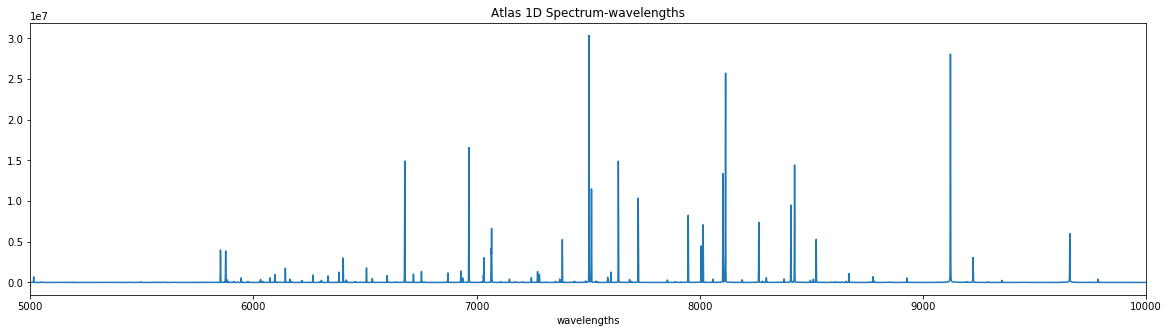

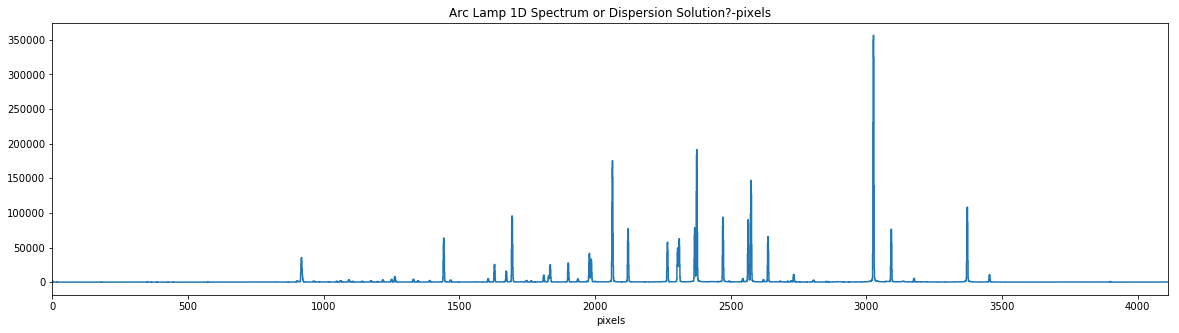

In [10]:
#running data pipeline to generate graphs for wl & pixel matching

#nameing all the datafiles needed
flatfiles = '20170518/red*.fits' #redside
atlasfiles = fits.open('henear.fits') #NOAO atlas #redside
arcfiles = '20170518/red0017.fits' #redside
linelist = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later
targetfile = '20170518/red0017.fits'#redside

#naming pipeline output for guess_plot use
specset = data_pipeline(flatfiles, atlasfiles, arcfiles, linelist)

### Collecting guesses from graphs above - manual intervention part

(9122.9673999999995, '9122.9674    ArI')

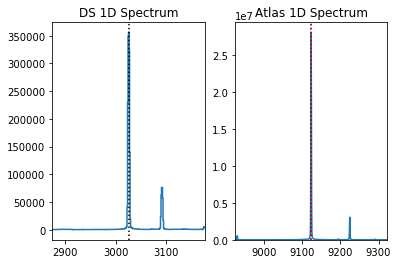

In [11]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset) #outputs (pixel guess, nearest wl/id in linelist)

In [12]:
#collect guesses here ~5 seems good
pixel_guesses = [3372,3027,2375,2065,1630]
atlas_lines = [9657.78,9122.9674,8115.31,7635.1,6965.43]

guesses = list(zip(pixel_guesses, atlas_lines)) #making tuples to pass into fcn later

### Using goodness_of_matches to generate residuals and more line matches based on guesses above

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0578827797865025, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, which is less than 10"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed t

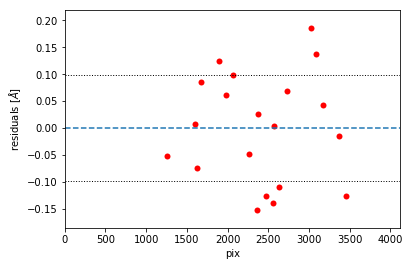

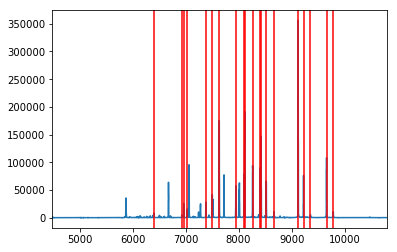

In [13]:
goodness_of_matches(targetfile,guesses)

# Red (1.0") --dispersion solution